In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Pandas with LaTeX rendering turned off
# This helps avoiding $DELL $HPE being printed as DELL(italic)
pd.options.display.html.use_mathjax = False

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Personal Projects/01 Sentiment Analysis Pipeline/Data/twitter-financial-news-sentiment (Hugging Face)/01/sent_train.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Personal Projects/01 Sentiment Analysis Pipeline/Data/twitter-financial-news-sentiment (Hugging Face)/01/sent_valid.csv')

# Display the first few rows
df_train.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


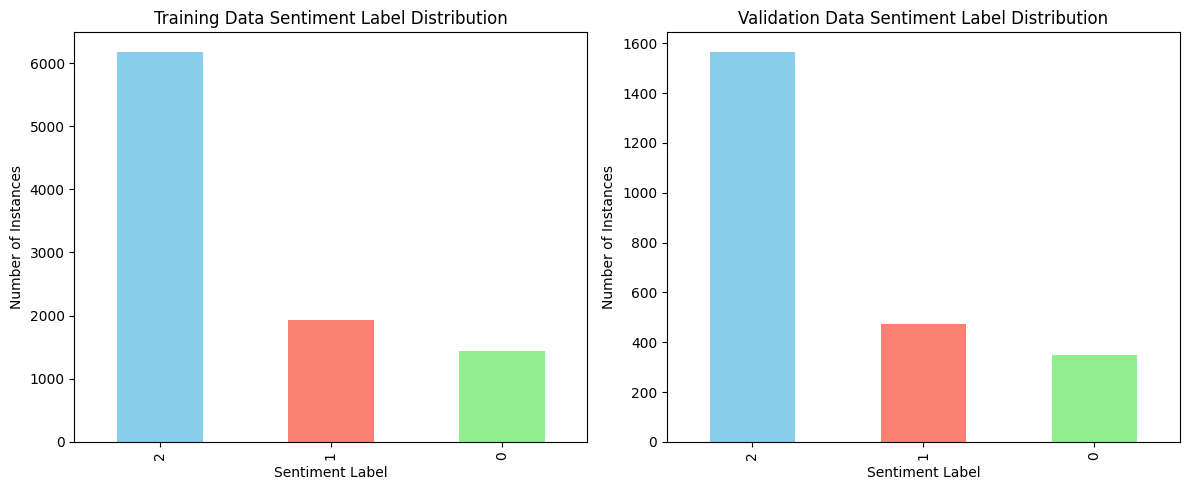

In [4]:
# Calculate the distribution of sentiment labels in the training dataset
train_label_counts = df_train['label'].value_counts()
valid_label_counts = df_valid['label'].value_counts()

# Display the counts as a bar chart for the training dataset
plt.figure(figsize=(12, 5))

# Training data label distribution
plt.subplot(1, 2, 1)
train_label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Training Data Sentiment Label Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Instances")

# Validation data label distribution
plt.subplot(1, 2, 2)
valid_label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Validation Data Sentiment Label Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Instances")

plt.tight_layout()
plt.show()

In [5]:
# Check for missing values in the training dataset
missing_train = df_train.isnull().sum()
print("Missing values in training data:\n", missing_train[missing_train > 0])

# Check for missing values in the validation dataset
missing_valid = df_valid.isnull().sum()
print("\nMissing values in validation data:\n", missing_valid[missing_valid > 0])

Missing values in training data:
 Series([], dtype: int64)

Missing values in validation data:
 Series([], dtype: int64)


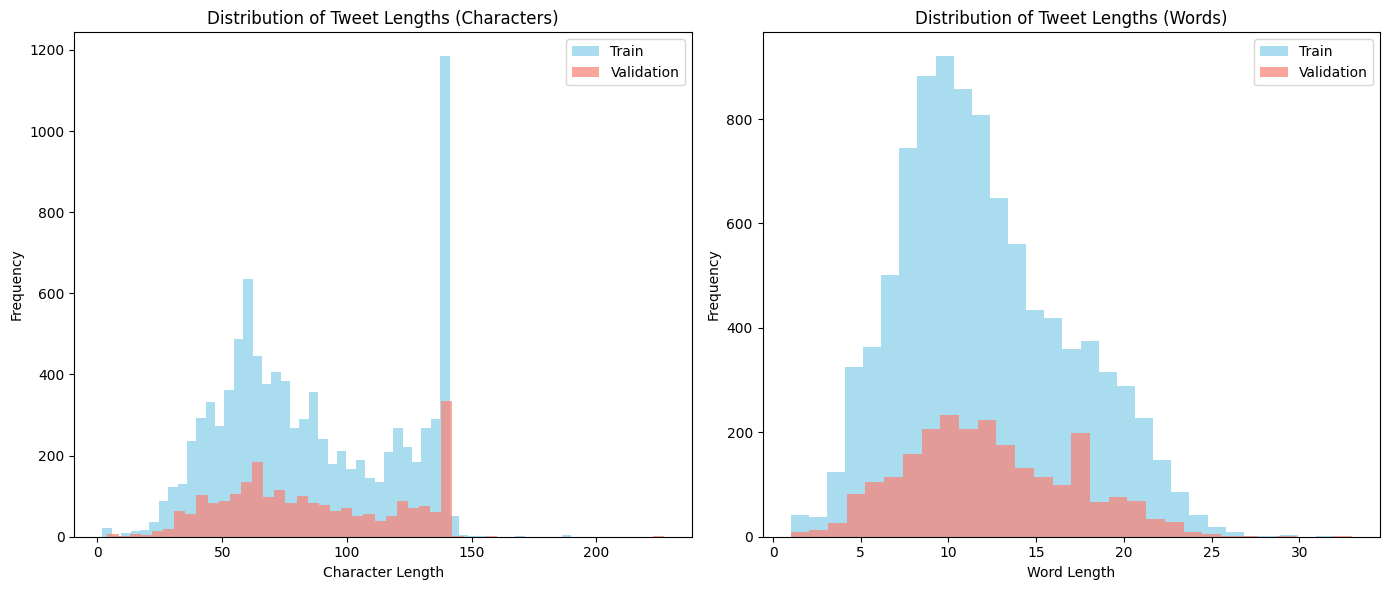

In [6]:
# Calculate tweet lengths in characters for both train and validation sets
df_train['char_length'] = df_train['text'].apply(len)
df_valid['char_length'] = df_valid['text'].apply(len)

# Calculate tweet lengths in words for both train and validation sets
df_train['word_length'] = df_train['text'].apply(lambda x: len(x.split()))
df_valid['word_length'] = df_valid['text'].apply(lambda x: len(x.split()))

# Plot distribution of tweet lengths in characters
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df_train['char_length'].plot(kind='hist', bins=50, alpha=0.7, color='skyblue', label='Train')
df_valid['char_length'].plot(kind='hist', bins=50, alpha=0.7, color='salmon', label='Validation')
plt.title("Distribution of Tweet Lengths (Characters)")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.legend()

# Plot distribution of tweet lengths in words
plt.subplot(1, 2, 2)
df_train['word_length'].plot(kind='hist', bins=30, alpha=0.7, color='skyblue', label='Train')
df_valid['word_length'].plot(kind='hist', bins=30, alpha=0.7, color='salmon', label='Validation')
plt.title("Distribution of Tweet Lengths (Words)")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Function to remove URLs from a text
def remove_urls(text):
    return re.sub(r'http\S+|www.\S+', '', text)

# Remove URLs from the text column in both train and validation sets
df_train['text'] = df_train['text'].apply(remove_urls)
df_valid['text'] = df_valid['text'].apply(remove_urls)

# Display the first few rows
df_train.head()

,text,label,char_length,word_length
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77,10
1,$CCL $RCL - Nomura points to bookings weakness...,0,102,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94,14
3,$ESS: BTIG Research cuts to Neutral,0,59,7
4,$FNKO - Funko slides after Piper Jaffray PT cut,0,71,10


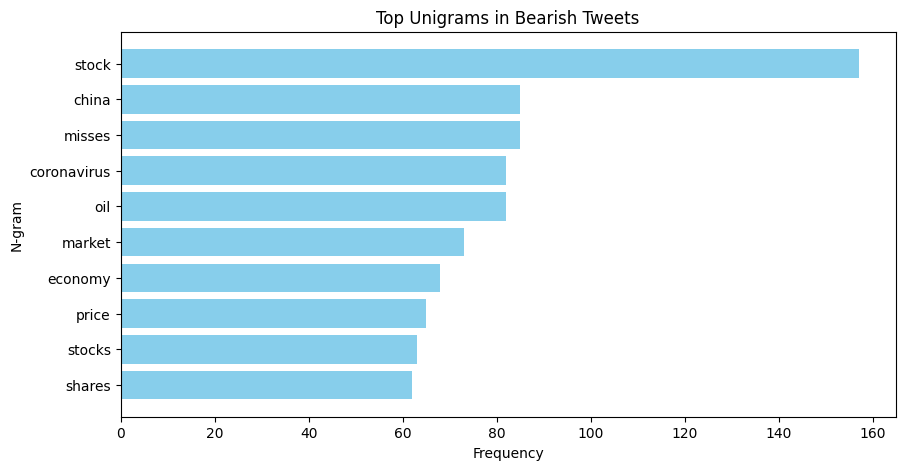

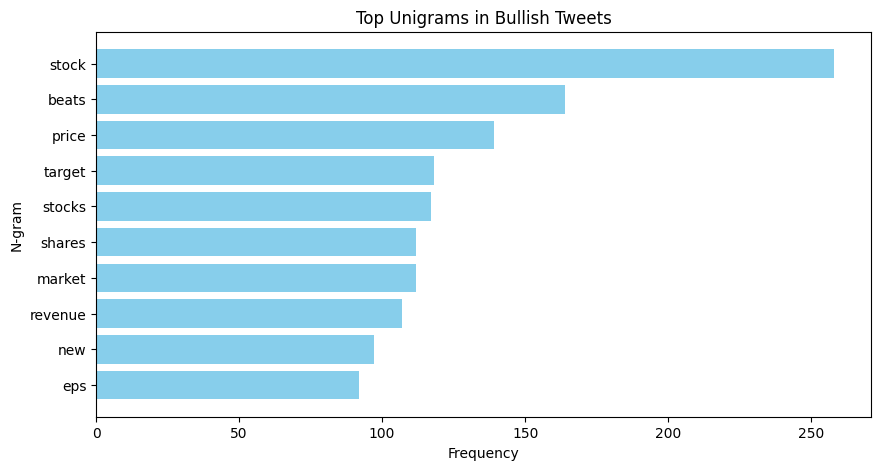

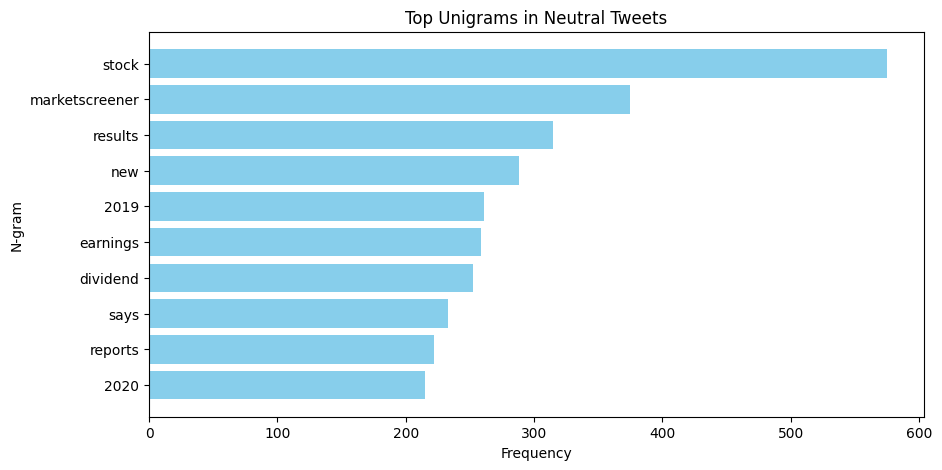

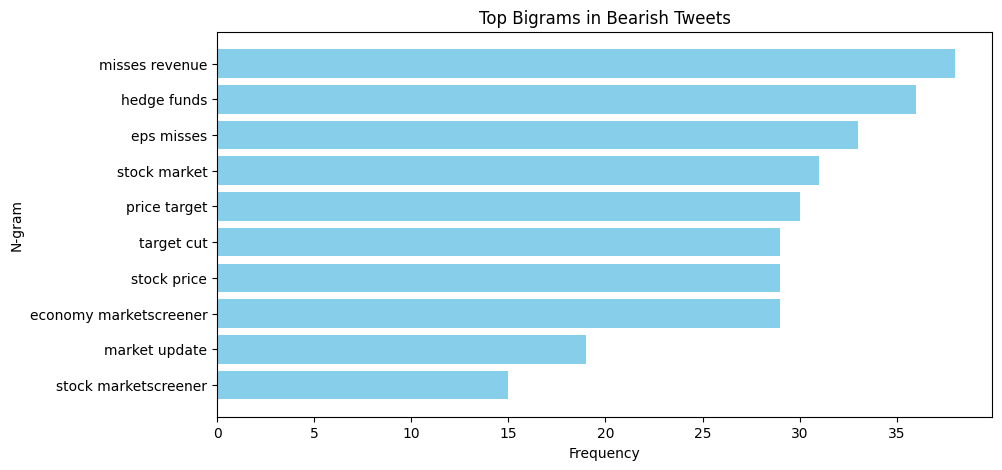

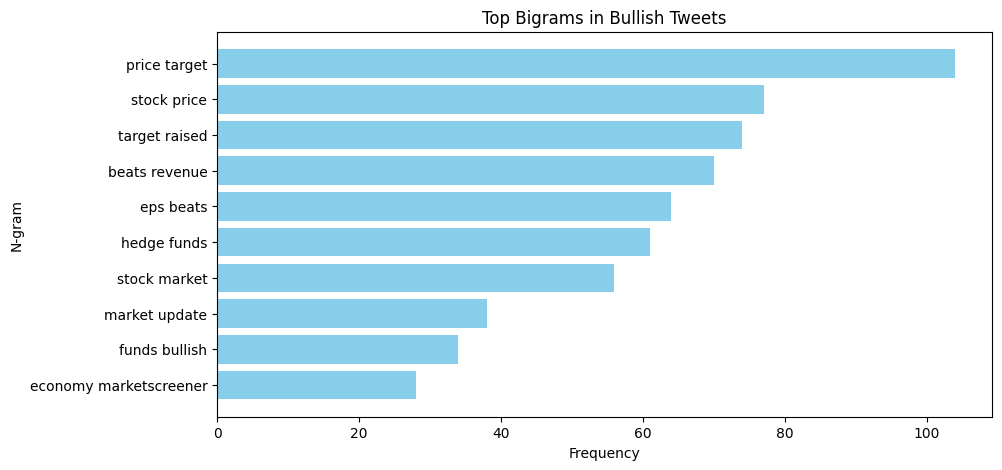

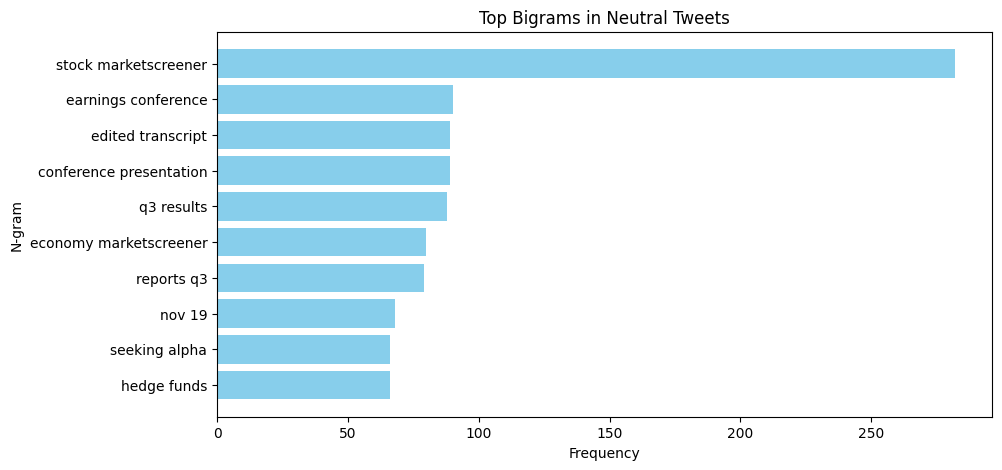

In [8]:
def plot_top_ngrams(corpus, ngram_range=(1, 1), top_n=10, title="Top N-grams"):
    # Initialize the CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngrams = vectorizer.fit_transform(corpus)

    # Sum up the counts of each n-gram
    sum_ngrams = ngrams.sum(axis=0)
    ngram_counts = [(ngram, sum_ngrams[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    ngram_counts = sorted(ngram_counts, key=lambda x: x[1], reverse=True)[:top_n]

    # Create DataFrame for plotting
    df_ngrams = pd.DataFrame(ngram_counts, columns=['Ngram', 'Count'])

    # Plot the n-grams
    plt.figure(figsize=(10, 5))
    plt.barh(df_ngrams['Ngram'], df_ngrams['Count'], color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show top counts at the top
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.show()

# Separate tweets by sentiment
bearish_tweets = df_train[df_train['label'] == 0]['text']
bullish_tweets = df_train[df_train['label'] == 1]['text']
neutral_tweets = df_train[df_train['label'] == 2]['text']

# Plot top unigrams for each sentiment
plot_top_ngrams(bearish_tweets, ngram_range=(1, 1), top_n=10, title="Top Unigrams in Bearish Tweets")
plot_top_ngrams(bullish_tweets, ngram_range=(1, 1), top_n=10, title="Top Unigrams in Bullish Tweets")
plot_top_ngrams(neutral_tweets, ngram_range=(1, 1), top_n=10, title="Top Unigrams in Neutral Tweets")

# Plot top bigrams for each sentiment
plot_top_ngrams(bearish_tweets, ngram_range=(2, 2), top_n=10, title="Top Bigrams in Bearish Tweets")
plot_top_ngrams(bullish_tweets, ngram_range=(2, 2), top_n=10, title="Top Bigrams in Bullish Tweets")
plot_top_ngrams(neutral_tweets, ngram_range=(2, 2), top_n=10, title="Top Bigrams in Neutral Tweets")

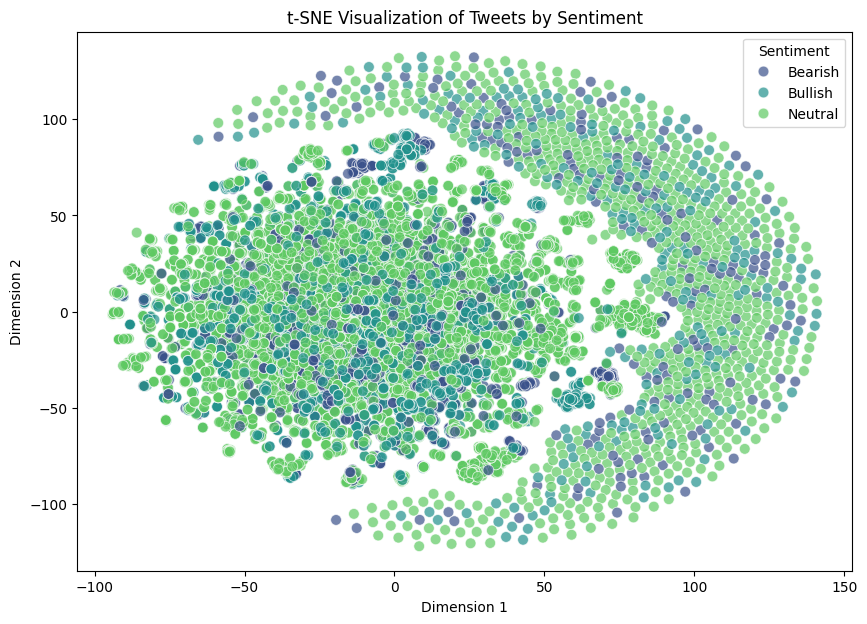

In [9]:
# Step 1: Convert text data to TF-IDF embeddings
tfidf = TfidfVectorizer(max_features=500)  # Limit features for visualization simplicity
X_tfidf = tfidf.fit_transform(df_train['text'])

# Step 2: Dimensionality Reduction with t-SNE or PCA
# For visualization, let's use t-SNE to project data to 2D space
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reduced = tsne.fit_transform(X_tfidf.toarray())

# Step 3: Plotting
# Create a DataFrame with the reduced dimensions and sentiment labels
df_plot = pd.DataFrame(X_reduced, columns=['Dimension 1', 'Dimension 2'])
df_plot['Sentiment'] = df_train['label'].map({0: 'Bearish', 1: 'Bullish', 2: 'Neutral'})

# Plot the results with seaborn for better styling
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='Dimension 1', y='Dimension 2', hue='Sentiment', palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Visualization of Tweets by Sentiment")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Sentiment")
plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

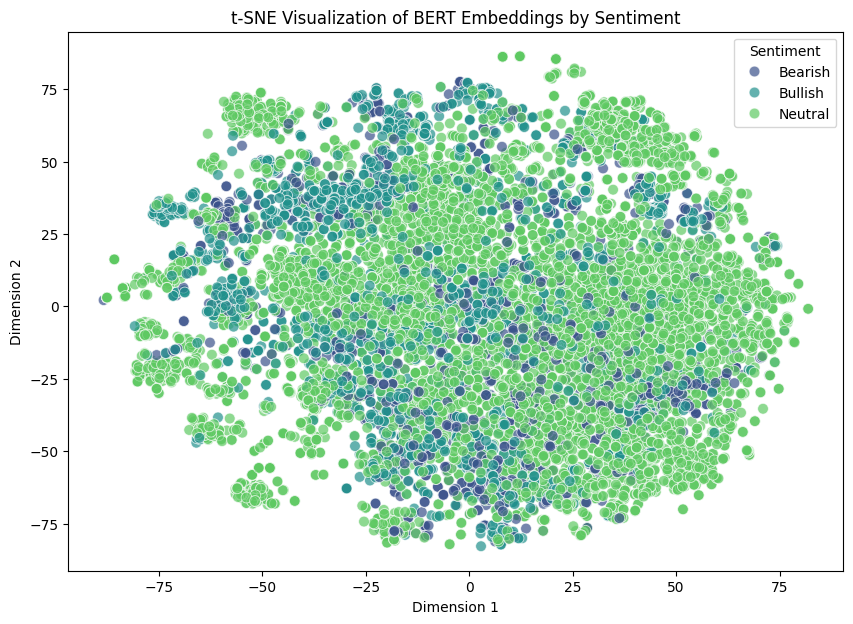

In [10]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings for a text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the last hidden states as the sentence embedding
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Generate embeddings for each tweet in the training data
df_train['embedding'] = df_train['text'].apply(get_bert_embedding)

# Stack embeddings into a 2D array
X_bert = np.vstack(df_train['embedding'].values)

# Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
X_reduced = tsne.fit_transform(X_bert)

# Plotting
df_plot = pd.DataFrame(X_reduced, columns=['Dimension 1', 'Dimension 2'])
df_plot['Sentiment'] = df_train['label'].map({0: 'Bearish', 1: 'Bullish', 2: 'Neutral'})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='Dimension 1', y='Dimension 2', hue='Sentiment', palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Visualization of BERT Embeddings by Sentiment")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Sentiment")
plt.show()